Exercise 1: Total Energy used (Input Energy): 469.58 kWh
Exercise 2: Average Pump Efficiency: 74.05 %
Exercise 3: Unused Energy: 121.87 kWh
Exercise 4: Total Hydraulic Energy: 347.72 kWh


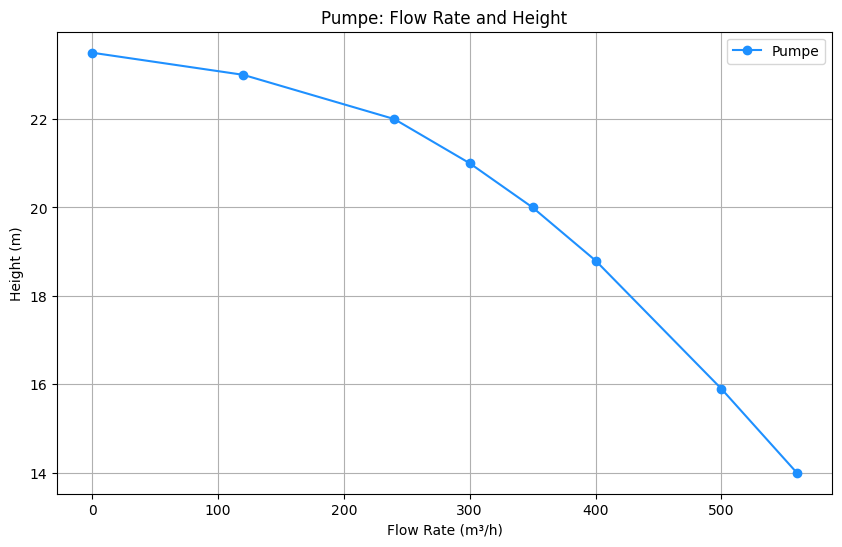

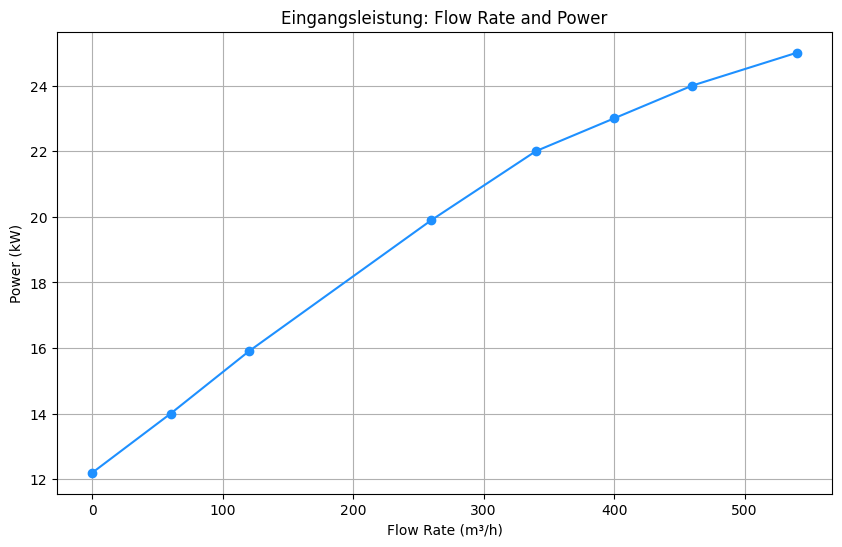

<Figure size 800x600 with 0 Axes>

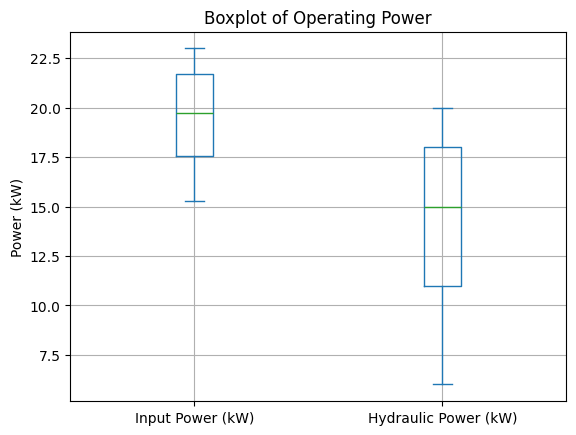

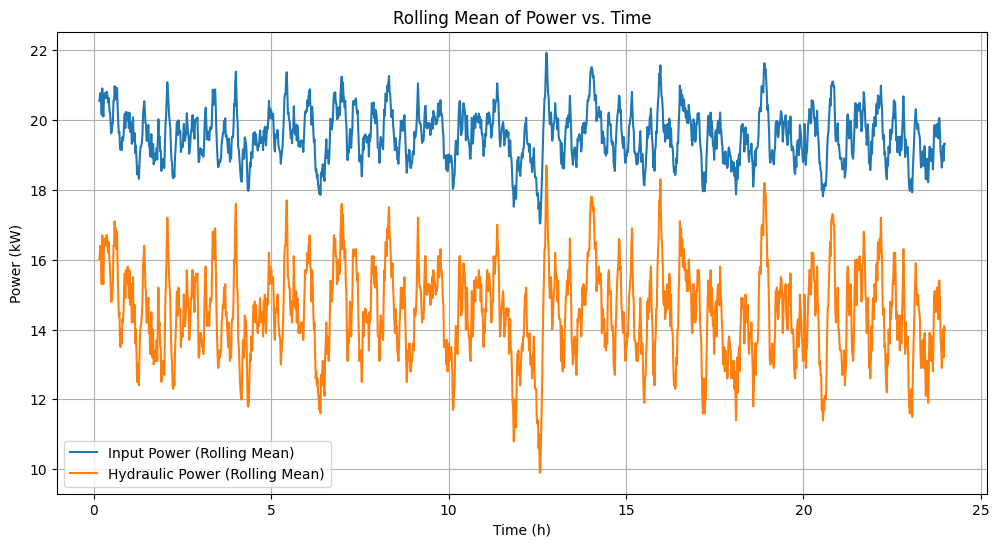

<Figure size 800x600 with 0 Axes>

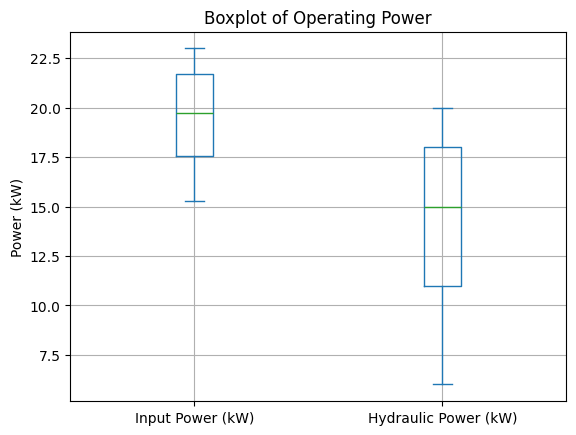

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ============================================================================
#      Daten laden und Beispiel-Datensätze erzeugen
# ============================================================================

# df_1: Messdaten aus CSV (Volume Flow in m³/h)
df_1 = pd.read_csv("volume_flow_data.csv")

# df_2: Kennliniendaten für die Pumpenhöhe (in m) als Funktion des Volumenstroms
data_2 = {
    "Flow Rate (m^3/h)": [0, 120, 240, 300, 350, 400, 500, 560],
    "height (m)": [23.5, 23, 22, 21, 20, 18.8, 15.9, 14]
}
df_2 = pd.DataFrame(data_2)

# df_3: Kennliniendaten für die Eingangsleistung (in kW) als Funktion des Volumenstroms
data_3 = {
    "Flow Rate (m^3/h)": [0, 60, 120, 260, 340, 400, 460, 540],
    "Power (kW)": [12.2, 14, 15.9, 19.9, 22, 23, 24, 25]
}
df_3 = pd.DataFrame(data_3)

# ============================================================================
#      Konstanten und Umrechnungen
# ============================================================================

rho = 1000   # Dichte des Wassers in kg/m³
g = 9.81     # Erdbeschleunigung in m/s²

# Umrechnung des Volumenstroms von m³/h in m³/s (1 m³/h = 1/3600 m³/s)
df_1["Q (m^3/s)"] = df_1["Volume Flow (m^3/h)"] / 3600.0

# Angenommen, jedes Messintervall repräsentiert 1 Minute
# => Zeitintervall in Stunden: 1/60 h
time_interval_hours = 1 / 60.0

# ============================================================================
#      Aufgabe 1: Berechnung der Input-Energie (basierend auf df_3)
# ============================================================================

# Erstelle Interpolationsfunktion für die Eingangsleistung (aus df_3)
f_input_power = interp1d(
    df_3["Flow Rate (m^3/h)"].values,
    df_3["Power (kW)"].values,
    kind="linear", fill_value="extrapolate")

# Wende die Interpolationsfunktion auf jeden Messwert in df_1 an,
# um den jeweiligen Eingangsleistungswert (in kW) zu erhalten.
df_1["Input Power (kW)"] = f_input_power(df_1["Volume Flow (m^3/h)"])

# Berechne die Energie pro Messintervall (in kWh)
# Energie = Leistung (kW) * Zeit (h)
df_1["Input Energy (kWh)"] = df_1["Input Power (kW)"] * time_interval_hours

# Summiere alle Einzelenergien, um die Gesamt-Energie zu erhalten
total_input_energy = df_1["Input Energy (kWh)"].sum()
print("Exercise 1: Total Energy used (Input Energy): {:.2f} kWh".format
      (total_input_energy))

# ============================================================================
#      Aufgabe 2: Berechnung der hydraulischen Energie (basierend auf df_2)
# ============================================================================

# Erstelle Interpolationsfunktion für den Pumpenkopf aus df_2
f_head = interp1d(
    df_2["Flow Rate (m^3/h)"].values,
    df_2["height (m)"].values,
    kind='linear', fill_value="extrapolate")

# Berechne die momentane hydraulische Leistung in Watt:
# P = ρ * g * H * Q  (wobei H über f_head interpoliert wird)
hydraulic_power_W = rho * g * f_head(df_1["Volume Flow (m^3/h)"]) * df_1["Q (m^3/s)"]

# Umrechnung der momentanen Leistung in kW
hydraulic_power_kW = hydraulic_power_W / 1000.0
df_1["Hydraulic Power (kW)"] = hydraulic_power_kW.round()

# Berechne die hydraulische Energie pro Messintervall (in kWh)
df_1["Hydraulic Energy (kWh)"] = df_1["Hydraulic Power (kW)"] * time_interval_hours

# Summiere alle hydraulischen Energie-Werte
total_hydraulic_energy = df_1["Hydraulic Energy (kWh)"].sum()

# Berechne den durchschnittlichen Pumpenwirkungsgrad (in %)
pump_efficiency = (total_hydraulic_energy / total_input_energy) * 100
print("Exercise 2: Average Pump Efficiency: {:.2f} %".format(pump_efficiency))

# ============================================================================
#      Aufgabe 3: Berechnung der ungenutzten Energie (Verluste)
# ============================================================================

unused_energy = total_input_energy - total_hydraulic_energy
print("Exercise 3: Unused Energy: {:.2f} kWh".format(unused_energy))

print("Exercise 4: Total Hydraulic Energy: {:.2f} kWh".format
      (total_hydraulic_energy))

# ============================================================================
#      Aufgabe 4: Zusatzfunktionen
# ============================================================================

# Optionaler Plot: Höhe vs. Volumenstrom
plt.figure(figsize=(10, 6))
plt.plot(df_2["Flow Rate (m^3/h)"], df_2["height (m)"],
         marker="o", linestyle="-", color="dodgerblue", label="Pumpe")
plt.xlabel("Flow Rate (m³/h)")
plt.ylabel("Height (m)")
plt.title("Pumpe: Flow Rate and Height")
plt.grid(True)
plt.legend()
plt.show()

# Optionaler Plot: Eingangsleistung vs. Volumenstrom
plt.figure(figsize=(10, 6))
plt.plot(df_3["Flow Rate (m^3/h)"], df_3["Power (kW)"],
         marker="o", linestyle="-", color="dodgerblue")
plt.xlabel("Flow Rate (m³/h)")
plt.ylabel("Power (kW)")
plt.title("Eingangsleistung: Flow Rate and Power")
plt.grid(True)
plt.show()

# 3. Boxplot: Betriebsverhalten (Vergleich von Input- und hydraulischer Leistung)
plt.figure(figsize=(8,6))
df_1[["Input Power (kW)", "Hydraulic Power (kW)"]].plot(kind="box", grid=True)
plt.title("Boxplot of Operating Power")
plt.ylabel("Power (kW)")
plt.show()

# Erzeuge eine Zeitachse (in Stunden) – jedes Messintervall entspricht 1 Minute.
df_1["Time (h)"] = df_1.index * time_interval_hours

# 4. Plot: Gleitender Mittelwert (Rolling Mean) der Leistungswerte
window_size = 10  # z. B. 10 Messintervalle
df_1["Input Power (Rolling Mean)"] = df_1["Input Power (kW)"].rolling(window=window_size).mean()
df_1["Hydraulic Power (Rolling Mean)"] = df_1["Hydraulic Power (kW)"].rolling(window=window_size).mean()

plt.figure(figsize=(12,6))
plt.plot(df_1["Time (h)"], df_1["Input Power (Rolling Mean)"], label="Input Power (Rolling Mean)")
plt.plot(df_1["Time (h)"], df_1["Hydraulic Power (Rolling Mean)"], label="Hydraulic Power (Rolling Mean)")
plt.xlabel("Time (h)")
plt.ylabel("Power (kW)")
plt.title("Rolling Mean of Power vs. Time")
plt.legend()
plt.grid(True)
plt.show()
